In [151]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
%load_ext line_profiler
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (11,8)
from sklearn.ensemble import RandomForestRegressor

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [177]:
from merf.utils import MERFDataGenerator
#from merf.merf import MERF
from merf.merf2 import MERF

# Test Data Generation

In [153]:
dgm = MERFDataGenerator(m=.6, sigma_b=np.sqrt(4.5), sigma_e=1)

In [154]:
num_clusters_each_size = 20
train_sizes = [1, 3, 5, 7, 9]
known_sizes = [9, 27, 45, 63, 81]
new_sizes = [10, 30, 50, 70, 90]

In [155]:
# Smaller set that can be used for debugging
# num_clusters_each_size = 1
# train_sizes = [1, 3]
# known_sizes = [9, 27]
# new_sizes = [10, 30]

In [156]:
train_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(train_sizes, num_clusters_each_size)
known_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(known_sizes, num_clusters_each_size)
new_cluster_sizes = MERFDataGenerator.create_cluster_sizes_array(new_sizes, num_clusters_each_size)

In [157]:
len(train_cluster_sizes), len(known_cluster_sizes), len(new_cluster_sizes)

(100, 100, 100)

In [158]:
train, test_known, test_new, training_cluster_ids, ptev, prev = dgm.generate_split_samples(train_cluster_sizes, known_cluster_sizes, new_cluster_sizes)

INFO     [utils.py:165] Drew 10000 samples from 200 clusters.
INFO     [utils.py:166] PTEV = 90.21192737667293, PREV = 48.82539159268796.


In [159]:
len(train), len(test_known), len(test_new)

(500, 4500, 5000)

In [160]:
train.head()

,y,X_0,X_1,X_2,Z,cluster
0,4.706758,0.526173,-0.892254,-0.730543,1.0,0
10,4.331225,-0.143819,-1.058211,0.127640,1.0,1
20,4.119783,0.193656,0.282264,-0.434614,1.0,2
30,2.846856,0.334433,1.604539,1.227075,1.0,3
40,2.607580,1.077123,0.419011,1.352674,1.0,4


# MERF Training

In [178]:
X_train = train[['X_0', 'X_1', 'X_2']]
Z_train = train[['Z']]
clusters_train = train['cluster']
y_train = train['y']

## Default MERF

In [179]:
mrf = MERF(max_iterations=30)
mrf.fit(X_train, Z_train, clusters_train, y_train)

INFO     [merf2.py:264] GLL is 338.14459601574225 at iteration 1.
INFO     [merf2.py:264] GLL is 392.1996003540764 at iteration 2.
INFO     [merf2.py:264] GLL is 372.8926443504506 at iteration 3.
INFO     [merf2.py:264] GLL is 421.79911001642 at iteration 4.
INFO     [merf2.py:264] GLL is 433.582655479147 at iteration 5.
INFO     [merf2.py:264] GLL is 494.57415328216547 at iteration 6.
INFO     [merf2.py:264] GLL is 419.86418508674205 at iteration 7.
INFO     [merf2.py:264] GLL is 423.8947749665435 at iteration 8.
INFO     [merf2.py:264] GLL is 480.32416956746454 at iteration 9.
INFO     [merf2.py:264] GLL is 431.1656481770433 at iteration 10.
INFO     [merf2.py:264] GLL is 426.52173855883035 at iteration 11.
INFO     [merf2.py:264] GLL is 465.5629761740841 at iteration 12.
INFO     [merf2.py:264] GLL is 368.91928360583677 at iteration 13.
INFO     [merf2.py:264] GLL is 375.80674449902824 at iteration 14.
INFO     [merf2.py:264] GLL is 484.1953233225875 at iteration 15.
INFO     [merf2

## LightGBM

In [189]:
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor()

In [191]:
mrf = MERF(lgbm, max_iterations=30)
mrf.fit(X_train, Z_train, clusters_train, y_train)

INFO     [merf2.py:264] GLL is 1055.2593219502003 at iteration 1.
INFO     [merf2.py:264] GLL is 1076.6610154276198 at iteration 2.
INFO     [merf2.py:264] GLL is 1074.0053434729803 at iteration 3.
INFO     [merf2.py:264] GLL is 1063.8883751868216 at iteration 4.
INFO     [merf2.py:264] GLL is 1067.2913249583503 at iteration 5.
INFO     [merf2.py:264] GLL is 1081.0492406722053 at iteration 6.
INFO     [merf2.py:264] GLL is 1073.153261548169 at iteration 7.
INFO     [merf2.py:264] GLL is 1062.302838111591 at iteration 8.
INFO     [merf2.py:264] GLL is 1071.4876882025474 at iteration 9.
INFO     [merf2.py:264] GLL is 1078.720003266296 at iteration 10.
INFO     [merf2.py:264] GLL is 1073.2895907152733 at iteration 11.
INFO     [merf2.py:264] GLL is 1072.9139161284577 at iteration 12.
INFO     [merf2.py:264] GLL is 1079.1852996146179 at iteration 13.
INFO     [merf2.py:264] GLL is 1081.5060617341148 at iteration 14.
INFO     [merf2.py:264] GLL is 1078.7163634571175 at iteration 15.
INFO   

Text(0.5, 0, 'Iteration')

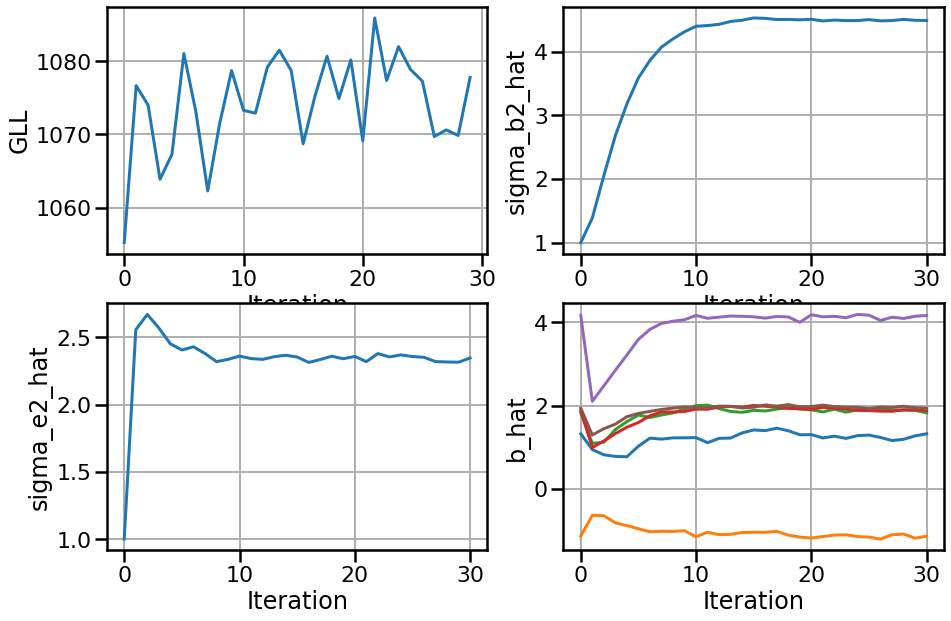

In [192]:
plt.figure(figsize=[15,10])
plt.subplot(221)
plt.plot(mrf.gll_history)
plt.grid('on')
plt.ylabel('GLL')
plt.xlabel('Iteration')

plt.subplot(222)
D_hat_history = [x[0][0] for x in mrf.D_hat_history]
plt.plot(D_hat_history)
plt.grid('on')
plt.ylabel('sigma_b2_hat')
plt.xlabel('Iteration')

plt.subplot(223)
plt.plot(mrf.sigma2_hat_history)
plt.grid('on')
plt.ylabel('sigma_e2_hat')
plt.xlabel('Iteration')

plt.subplot(224)
b_df = pd.concat(mrf.b_hat_history, axis=1)
b_df.columns = range(0, 31)
plt.plot(b_df.loc[0])
plt.plot(b_df.loc[20])
plt.plot(b_df.loc[30])
plt.plot(b_df.loc[40])
plt.plot(b_df.loc[50])
plt.plot(b_df.loc[60])
plt.grid('on')
plt.ylabel('b_hat')
plt.xlabel('Iteration')

Text(0.5, 1.0, 'Distribution of b_is')

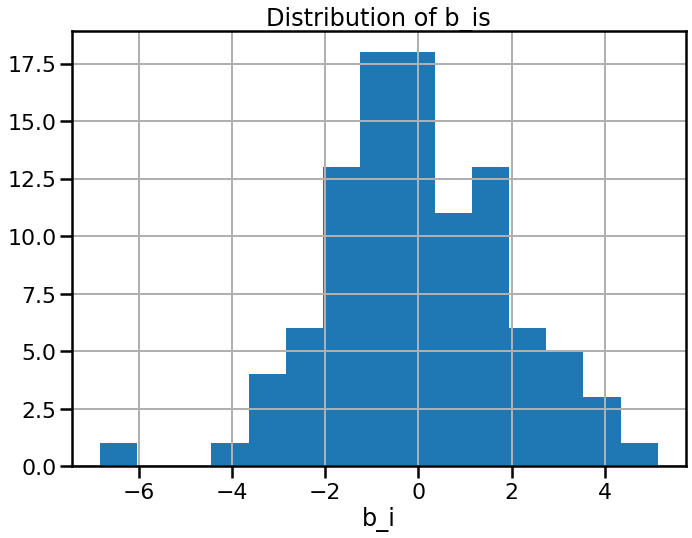

In [193]:
mrf.trained_b.hist(bins=15)
plt.xlabel('b_i')
plt.title('Distribution of b_is')

# Use Plotting Utilties in Evaluator

In [183]:
from merf.evaluator import plot_training_stats, plot_bhat

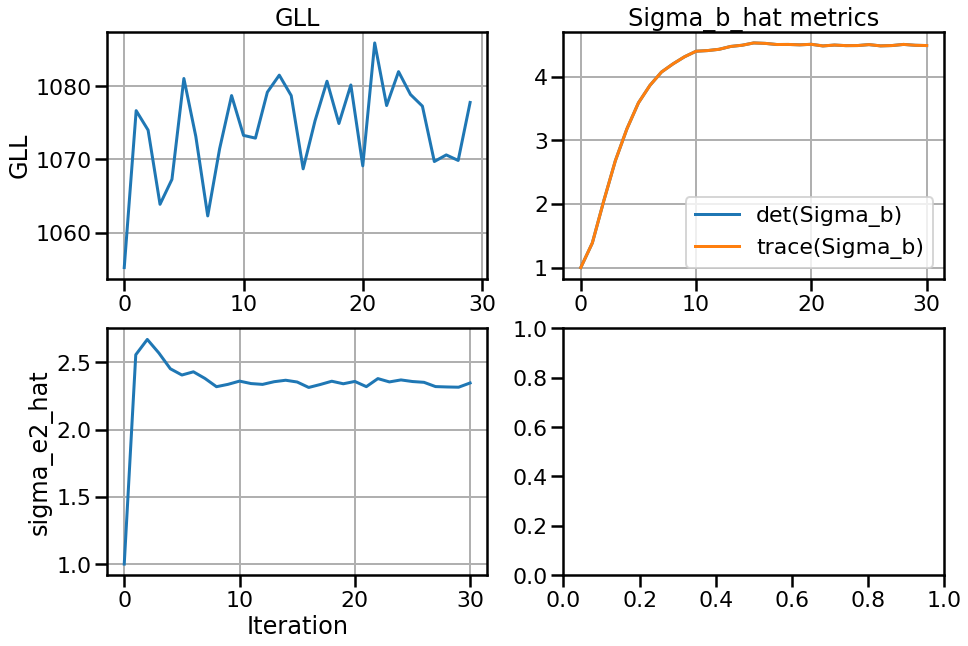

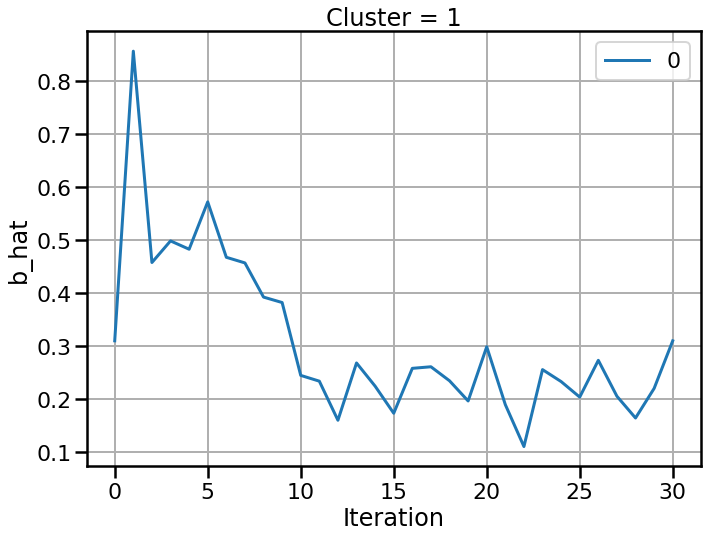

In [194]:
plot_training_stats(mrf)

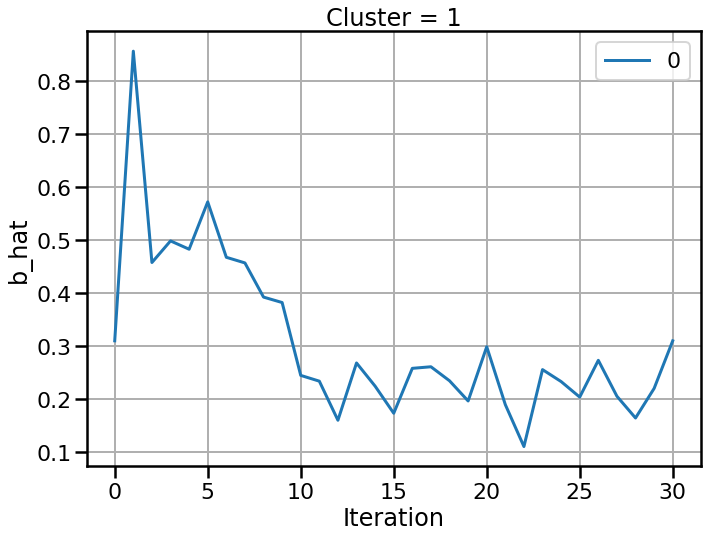

In [195]:
b_df = plot_bhat(mrf, 1)

# MERF Prediction

In [124]:
X_known = test_known[['X_0', 'X_1', 'X_2']]
Z_known = test_known[['Z']]
clusters_known = test_known['cluster']
y_known = test_known['y']

In [125]:
y_hat_known = mrf.predict(X_known, Z_known, clusters_known)
y_hat_known

array([-3.33786179,  1.0196584 , -0.3901869 , ...,  2.14927357,
       -0.63566302,  4.29675591])

In [126]:
assert len(y_hat_known) == len(y_known)

In [127]:
X_new = test_new[['X_0', 'X_1', 'X_2']]
Z_new = test_new[['Z']]
clusters_new = test_new['cluster']
y_new = test_new['y']

In [128]:
y_hat_new = mrf.predict(X_new, Z_new, clusters_new)
y_hat_new

array([ 4.22179162,  2.22037092,  1.1392021 , ...,  1.19191813,
       -1.12569847,  1.82051881])

In [129]:
assert len(y_hat_new) == len(y_new)

# Inspect Trained Random Forest

Specifically look at the partial dependence plots and feature importance (using SHAP). 

In [130]:
mrf.trained_fe_model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [132]:
from sklearn.inspection import plot_partial_dependence

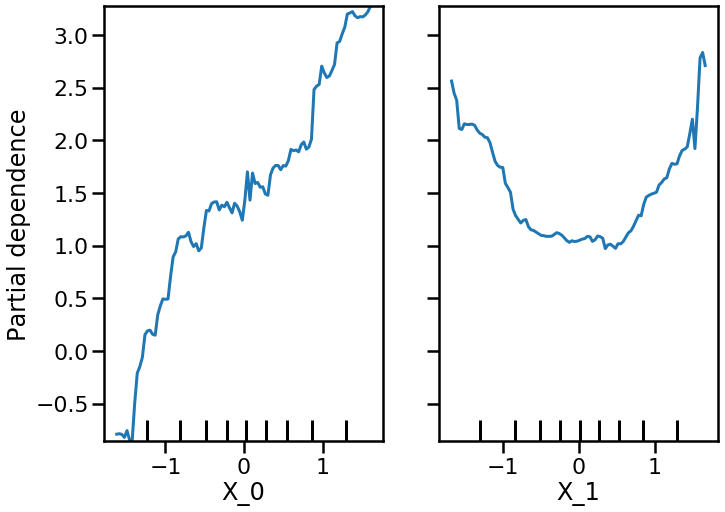

In [133]:
features = [0, 1]
plot_partial_dependence(mrf.trained_fe_model, X_known, features) 

In [134]:
import shap

In [135]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(mrf.trained_fe_model)
shap_values = explainer.shap_values(X_known)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


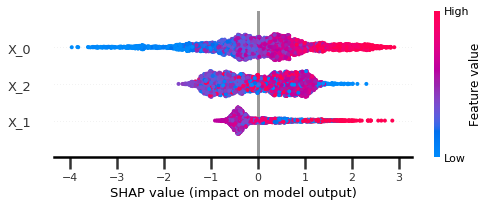

In [136]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_known)

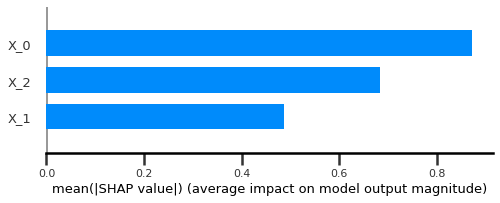

In [137]:
shap.summary_plot(shap_values, X_known, plot_type="bar")


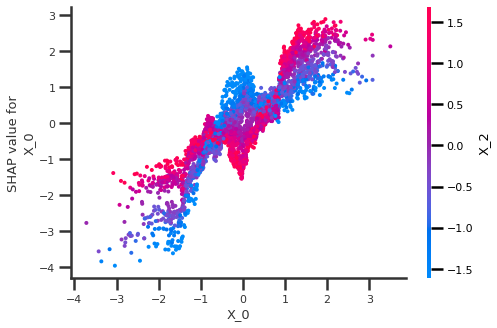

In [138]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('X_0', shap_values, X_known)

# MERF vs. Random Forest on Fixed Effects

In [ ]:
# Train and test using classic random forest. 
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [ ]:
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1)

In [ ]:
rf.fit(X_train, y_train)

In [ ]:
y_hat_known_rf = rf.predict(X_known)

In [ ]:
pmse_known_rf = np.mean((y_known - y_hat_known_rf) ** 2)
pmse_known_rf

In [ ]:
y_hat_known_merf = mrf.predict(X_known, Z_known, clusters_known)

In [ ]:
pmse_known_merf = np.mean((y_known - y_hat_known_merf) ** 2)
pmse_known_merf

In [ ]:
rd_known = 100 * (pmse_known_rf - pmse_known_merf) / pmse_known_rf
rd_known

In [ ]:
y_hat_new_rf = rf.predict(X_new)

In [ ]:
pmse_new_rf = np.mean((y_new - y_hat_new_rf) ** 2)
pmse_new_rf

In [ ]:
y_hat_new_merf = mrf.predict(X_new, Z_new, clusters_new)

In [ ]:
pmse_new_merf = np.mean((y_new - y_hat_new_merf) ** 2)
pmse_new_merf

In [ ]:
rd_new = 100 * (pmse_new_rf - pmse_new_merf) / pmse_new_rf
rd_new

# MERF vs Random Forest with OHE Cluster Ids

In [ ]:
rf_ohe = RandomForestRegressor(n_estimators=300, n_jobs=-1)

In [ ]:
categories = np.sort(clusters_train.unique())

In [ ]:
clusters_train_prime = pd.Categorical(clusters_train, categories=categories)

In [ ]:
X_ohe = pd.get_dummies(clusters_train_prime, prefix='cluster')

In [ ]:
X_ohe.head()

In [ ]:
X_train_ohe = pd.merge(X_train, X_ohe, left_index=True, right_index=True)

In [ ]:
rf_ohe.fit(X_train_ohe, y_train)

In [ ]:
clusters_known_prime = pd.Categorical(clusters_known, categories=categories)

In [ ]:
X_known_ohe = pd.get_dummies(clusters_known_prime, prefix='cluster')

In [ ]:
X_known_ohe.head()

In [ ]:
X_known_w_ohe = pd.merge(X_known, X_known_ohe, left_index=True, right_index=True)

In [ ]:
y_hat_known_rf_ohe = rf_ohe.predict(X_known_w_ohe)

In [ ]:
mse_known_rf_ohe = np.mean((y_known - y_hat_known_rf_ohe) ** 2)
mse_known_rf_ohe

In [ ]:
clusters_new_prime = pd.Categorical(clusters_new, categories=categories)

In [ ]:
X_new_ohe = pd.get_dummies(clusters_new_prime, prefix='cluster')

In [ ]:
X_new_ohe.head()

In [ ]:
X_new_w_ohe = pd.merge(X_new, X_new_ohe, left_index=True, right_index=True)

In [ ]:
y_hat_new_rf_ohe = rf_ohe.predict(X_new_w_ohe)

In [ ]:
mse_new_rf_ohe = np.mean((y_new - y_hat_new_rf_ohe) ** 2)
mse_new_rf_ohe